# Prediksi Nilai Tukar Rupia Terhadap Dolar

In [43]:
import pandas as pd
import numpy as np

# Preprocessing data
from sklearn.preprocessing import MinMaxScaler

# Model selection
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# evaluasi dan visualisasi
import matplotlib.pyplot as plt



In [2]:
# menimport data dasi file csv
data = pd.read_csv('Data/USD_IDR Historical Data (2).csv')

In [3]:
# menampilkan 5 data teratas
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,05/28/2025,"16,309.0","16,270.0","16,315.9","16,259.4",NaN,0.31%
1,05/27/2025,"16,259.4","16,270.0","16,281.0","16,225.0",NaN,0.12%
2,05/26/2025,"16,240.0","16,185.0","16,245.0","16,155.0",NaN,0.21%
3,05/25/2025,"16,206.0","16,215.0","16,218.0","16,206.0",NaN,-0.07%
4,05/23/2025,"16,217.5","16,320.0","16,330.5","16,215.0",NaN,-0.69%


 **Deskripsi Tiap Kolom**

Data merupakan nilai tukar mata uang rupiah ke dollar dimana data diambil dari https://www.investing.com/currencies/usd-idr-historical-data. Untuk rentan waktu yang diambil yaitu selama 3 tahun, mulai dari tahun 2023-2025 pertanggal 28 mei.
 - open: harga pembukaan dihari tersebut
 - hight: harga tertinggi dihari tersebut
 - low: harga atau nilai tukar mata uang terendah pada hari tersebut
 - price: price closeatau nilai tukar final mata uang pada hari tersebut (sebagai kolom target)
 - change %: persentase perubahan nilai tukar mata uang berdasarkan hari sebelumnya

In [4]:
data.shape

(1016, 7)

In [5]:
# melihat kolom yang terdapat nilai null atau nan
data.isna().sum()

Date          0
Price         0
Open          0
High          0
Low           0
Vol.        611
Change %      0
dtype: int64

**Noted**
dari total keseluruhan baris data adalah 524, pada kolom Vol seperti kita lihat bahwa keseluruan dari kolom bernilai nan atau null


# Preprocessing Data

In [6]:
# menghapus kolom yang tidak diperlukan
data.drop(columns=['Vol.'], inplace=True)

**Noted**

melakukan proses penghapusan kolom yang tidak diperlukan berdasarkan informasi yang telah didapatkan seblumnya, dimana kolom vol secarea keseluruhan bernilai kosong.

In [7]:
# megubah tanggal menjadi datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [8]:
# mengurutkan DataFrame berdasarkan tanggal dari yang paling lama ke yang terbaru
df = data.sort_values(by='Date', ascending=True)

In [9]:
# memisahkan kolom Date menjadi tahun, bulan, dan hari
df['Year'] = data['Date'].dt.year
df['Month'] = data['Date'].dt.month
df['Day'] = data['Date'].dt.day

In [10]:
# mengahaous kolom Date
df.drop(columns=['Date'], inplace=True)

**Noted**

pada langkah ini yaitu mengubah data date menjadi datetime menggunakan library pandas, dan mengurutkan data dari terlama hingga terbaru, proses selanjutnya yaitu memisahkan antara data hari, bulan, dan tahun menjadi sebuah kolom baru. Langkah terakhir yang dilakuka adalah menghapus kolom Date, alasannya yaitu karena data tanggal telah dipisah menjadi data hari, bulan, dan tahun

In [11]:
df.head()

,Price,Open,High,Low,Change %,Year,Month,Day
1015,"14,280.0","14,305.0","14,322.5","14,285.0",-0.04%,2021,5,28
1014,"14,275.0","14,295.0","14,312.0","14,280.0",-0.04%,2021,5,31
1013,"14,275.0","14,265.0","14,292.5","14,247.5",0.00%,2021,6,2
1012,"14,280.0","14,275.0","14,312.5","14,265.0",0.04%,2021,6,3
1011,"14,290.0","14,295.0","14,325.0","14,295.0",0.07%,2021,6,4


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 1015 to 0
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1016 non-null   object
 1   Open      1016 non-null   object
 2   High      1016 non-null   object
 3   Low       1016 non-null   object
 4   Change %  1016 non-null   object
 5   Year      1016 non-null   int32 
 6   Month     1016 non-null   int32 
 7   Day       1016 non-null   int32 
dtypes: int32(3), object(5)
memory usage: 59.5+ KB


In [13]:
# menghapus simbol yang tidak diperlukan dan mengubah tipe data kolom
df['Change %']= df['Change %'].str.replace('%', '').astype(float)
df['Price']= df['Price'].str.replace(',', '').astype(float)
df['Open']= df['Open'].str.replace(',', '').astype(float)
df['High']= df['High'].str.replace(',', '').astype(float)
df['Low']= df['Low'].str.replace(',', '').astype(float)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 1015 to 0
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1016 non-null   float64
 1   Open      1016 non-null   float64
 2   High      1016 non-null   float64
 3   Low       1016 non-null   float64
 4   Change %  1016 non-null   float64
 5   Year      1016 non-null   int32  
 6   Month     1016 non-null   int32  
 7   Day       1016 non-null   int32  
dtypes: float64(5), int32(3)
memory usage: 59.5 KB


**Noted**

pada pemrosesan data ini tahap yang dilakukandalah menhapus simbol-simbol yang tidak dibutuhkan nantinya, dan mengubah setiap tipe data menjadi float. karena seperti terlihat bahwa tipe data sebelumnya yaitu object, setelah dilakukan pemrosesan data maka diubah menjadi float. Tujuannya yaitu agar dapat digunakan nantinya dalam proses pelatihan model

In [15]:
# Proses Normalisasi Data
scalar = MinMaxScaler(feature_range=(0, 1))

scalar_featur = scalar.fit_transform(df[['Price', 'Open', 'High', 'Low', 'Change %']])

**NOted**

melakukan prose normalisasi dengan menggunakan minmascaler, tujuan normalisasi ini tnetunya agara setiap fitur nantinya memiliki scala yang sama dimana dalam rentang 0-1. penyeragaman scala pada setiap gitur itu penting untuk dilakukan karena disini saya menggunakan model LSTM seperti yang diketahui LSTM sangat sensistif terhadap skala data, selain itu dapat meningkatkan stabilitas pelatihan dan kecepatan konvergensi model.

In [16]:
# mengubah data dalam bentuk sequence
def sequence_data(data, seq_length):
    X=[]
    y=[]

    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
        
    return np.array(X), np.array(y)

In [17]:
X, y = sequence_data(scalar_featur, 30)

 **Noted**


 seperti yang terlihat proses ini bertujuan untuk mengubah data kedalam bentuk sequence, hal ini sangat penting dilakukan karena model LSTM bekerja sesuai dengan urutan data yang ada jadi ketika urutan tidak sesuai maka dapat mempengaruhi kinerja dari  model LSTM. sementara itu juga terdapat window atau seq_lengt hal ini berfungsi agar model dapat belajar dari urutan hari ke hari. Dengan menerapkan hal berikut diharapkan model nantinya dapat memprediksi nilai tukar mata uang IDR to USD keesokan harinya berdasarkan 30 hari terakhir.

In [18]:
# melakukan proses spliting data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Implementasi & Training Model

In [31]:
# Membangun model
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(30, 5)),  #layer 1
    Dropout(0.2),
    LSTM(16),                  #layer 2                                                         
    Dense(1)                                               #layer 3
])

In [32]:
# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

**Noted**

- input_shape = berisi 30 hari sebelumnya berdasarkan 5 fitur dalam satu harinya
- LSTM layer berjumlah 2 bertujuan untuk belajar data dan pola temporal
- dopout layer bertujuan untuk mencegah overfitting dengan membuat neuron secara acak saat training
- dense atau neuron berjumlah 1 bertujuan untuk melakukan proses prediksi nilai tunggal yaitu price

In [38]:


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=20,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop],
    verbose=1

    )


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0111 - val_loss: 0.0219
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0107 - val_loss: 0.0219
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - val_loss: 0.0219
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - val_loss: 0.0219
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0101 - val_loss: 0.0223
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0115 - val_loss: 0.0219
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0109 - val_loss: 0.0219
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0109 - val_loss: 0.0221
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0114 - val_loss: 0.0220
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0103 - val_loss: 0.0228
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0102 - val_loss: 0.0226
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

**Noted**

seperti yang terlihat dengan menggunakan epoch 50 nilai loss mengalami penurunan yang cukup besar,walaupun sempat terjadi kenaikan sedikit dimana nilai akhir loss 0.0108. Untuk jilai Val_loss 0.0223, dari hail yang didapatkan model mengalami overfitting sedikit. dimana model memberikan hasil yang bagus saat pelatihan akan tetapi mengalami penurunan saat melakukan uji coba model

#   Evaluuasi Model dan visualisasi model

In [48]:
# Prediksi data uji
y_pred = model.predict(X_test)

# Mengambil kolom Price saja dari y_test (kolom pertama)
y_test_price = y_test[:, 0]

# Hitung metrik
mse = mean_squared_error(y_test_price, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_price, y_pred)
r2 = r2_score(y_test_price, y_pred)

print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MSE  : 0.0068
RMSE : 0.0826
MAE  : 0.0719
R²   : 0.7424


**Noted**

proses yang telah dilakukan sebelumnya merupakan proses evluasi model, dimana tujuan dari evaluasi model adalah untuk melihat seberapa baik model dalam bekerja. Berdasarkan hasil yang ada model menunjukkan peforma yang cukup baik, seperti yang terlihat tingkat error relatif kecil pada nilai MSE dan RMSE dan R^2 memiliki nilai diatas 0.7 artinya model mampu menjelaskan sebagian besar variansi yang ada didalam target.

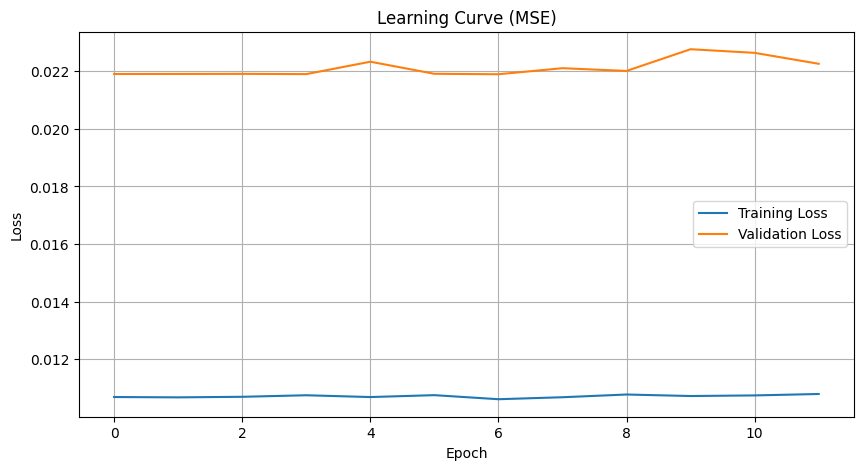

In [ ]:
# visualisasi hasil prediksi vs training data
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Noted**

berdasarkan hasil visualisasi dapat disimpulkan bahwa training loss cendrung strabil, sehingga tidak terjadi ovefitting karena seperti yang kita lihat antara nilai dari training loss dan validation loss sangat stabil. tidak terjadi juga under fitting walaupun training loss rendah akan tetapi nilai dari validation loss tidak terpaut terlalu jauh. 

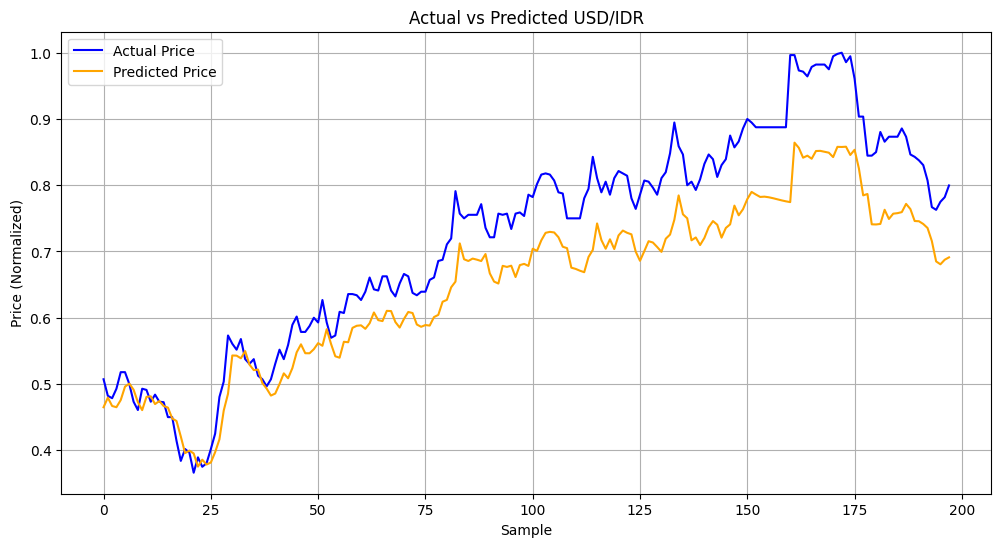

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_price, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted USD/IDR')
plt.xlabel('Sample')
plt.ylabel('Price (Normalized)')
plt.legend()
plt.grid(True)
plt.show()

**Noted**

berdasarkan hasil visualisasi yang telah dibuat, dapat disimpulkan bahwa model berhasil memahami arah dari pergrakan price, tapi masih mengalami kekurangan dalam besaran yang ada. Hal ini menunjukkan bahwa model mengalami sedikit lagging dalam merespon perubahan yang tajam.

**Noted**

rekomendasi yang dapat dilakukan untuk kedepannya yaitu:
- kemungkinan model belum terlalu cukup dalam, saran yang diberikan bisa menambah lapisan pada model, atau bisa juga mencoba model lain.
- jumlah data masih terbatas, bisa menambahkan data lebih banyak dan lebih kompleks lagi mulai dari fitur fitur yang digunakan. sehingga nantinya dapat membantu dalam meningkatkan akurasi model.
- seprti yang telah dijelaskan sebelumnya dapat menambahan fitur seperti suku bunga, inflasi, dll.

jadi dapat disimpulkan perbaikan yang disarankan terhadap pembuatan traininf model ini yaitu bisa menambahkan fitur, tuning hyperparameter, mencoba menggunakan model seperti GRU/BI-LSTM